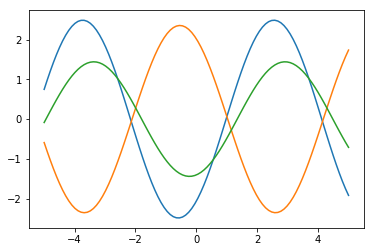

In [108]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import torch

class SineWaveTask:
    def __init__(self):
        self.a = np.random.uniform(0.1, 5.0)
        self.b = np.random.uniform(0, 2*np.pi)
        self.train_x = None
        
    def f(self, x):
        return self.a * np.sin(x + self.b)
        
    def training_set(self, size=10, force_new=False):
        if self.train_x is None and not force_new:
            self.train_x = np.random.uniform(-5, 5, size)
            x = self.train_x
        elif not force_new:
            x = self.train_x
        else:
            x = np.random.uniform(-5, 5, size)
        y = self.f(x)
        return torch.Tensor(x), torch.Tensor(y)
    
    def test_set(self, size=50):
        x = np.linspace(-5, 5, size)
        y = self.f(x)
        return torch.Tensor(x), torch.Tensor(y)
    
    def plot(self, *args, **kwargs):
        x, y = self.test_set(size=100)
        return plt.plot(x.numpy(), y.numpy(), *args, **kwargs)
    
    def plot_model(self, new_model, *args, **kwargs):
        x, y_true = self.test_set(size=100)
        x = Variable(x[:, None])
        y_true = Variable(y_true[:, None])    

        y_pred = new_model(x)

        plt.plot(x.data.numpy().flatten(),
                 y_pred.data.numpy().flatten(),
                 *args, **kwargs)

TRAIN_SIZE = 10000
TEST_SIZE = 1000
SINE_TRAIN = [SineWaveTask() for _ in range(TRAIN_SIZE)]
SINE_TEST = [SineWaveTask() for _ in range(TEST_SIZE)]
        
SineWaveTask().plot()
SineWaveTask().plot()
SineWaveTask().plot()
plt.show()

In [109]:
from torch import nn
from torch.autograd import Variable

class SineModel(nn.Module):
    
    def __init__(self):
        nn.Module.__init__(self)
        
        self.main = nn.Sequential(
            nn.Linear(1, 40),
            nn.ReLU(),            
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 1),
        )
        
    def forward(self, x):
        return self.main(x)

In [111]:
def do_base_learning(model, wave, lr_inner, n_inner):
    new_model = SineModel()
    new_model.load_state_dict(model.state_dict())  # copy? looks okay
    inner_optimizer = torch.optim.SGD(new_model.parameters(), lr=lr_inner)
    # K steps of gradient descent
    for i in range(n_inner):

        x, y_true = wave.training_set()
        x = Variable(x[:, None])
        y_true = Variable(y_true[:, None])

        y_pred = new_model(x)

        loss = ((y_pred - y_true)**2).mean()

        inner_optimizer.zero_grad()
        loss.backward()
        inner_optimizer.step()
    return new_model


def do_base_eval(new_model, wave):
    x, y_true = wave.test_set()
    x = Variable(x[:, None])
    y_true = Variable(y_true[:, None])    
    
    y_pred = new_model(x)
    
    loss = ((y_pred - y_true)**2).mean()
    return loss.data[0]
    
        
def reptile_sine(model, iterations, lr_inner=0.01, 
                 lr_outer=0.001, n_inner=3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_outer)

    train_metalosses =[]
    test_metalosses = []
    
    # Sample an epoch by shuffling all training tasks
    for t in xrange(iterations):
        
        # Sample task
        wave = random.sample(SINE_TRAIN, 1)[0]

        # Take k gradient steps
        new_model = do_base_learning(model, wave, lr_inner, n_inner)

        # Eval
        train_metaloss = do_base_eval(new_model, wave)        
        
        # Inject updates into each .grad
        for p, new_p in zip(model.parameters(), new_model.parameters()):
            if p.grad is None:
                p.grad = Variable(torch.zeros(p.size()))
            p.grad.data.add_(p.data - new_p.data)

        # Update meta-parameters
        optimizer.step()
        optimizer.zero_grad()
    
    
        ############# Validation
        wave = random.sample(SINE_TEST, 1)[0]
        new_model = do_base_learning(model, wave, lr_inner, n_inner)
        test_metaloss = do_base_eval(new_model, wave)
        
        ############# Log
        train_metalosses.append(train_metaloss)
        test_metalosses.append(test_metaloss)
        
        if t % 1000 == 0:
            print 'Iteration', t
            print 'AvgTrainML', np.mean(train_metalosses)
            print 'AvgTestML ', np.mean(test_metalosses)
            
 
model = SineModel()
reptile_sine(model, iterations=100000)

Iteration 0
AvgTrainML 3.713319778442383
AvgTestML  4.267566204071045
Iteration 1000
AvgTrainML 4.014877403469907
AvgTestML  3.898476217036972
Iteration 2000
AvgTrainML 3.9898762762860005
AvgTestML  3.832974507931158
Iteration 3000
AvgTrainML 3.9268840070118274
AvgTestML  3.7663845875360518
Iteration 4000
AvgTrainML 3.823301656381815
AvgTestML  3.642814967359638
Iteration 5000
AvgTrainML 3.62337461137697
AvgTestML  3.48397386315014
Iteration 6000
AvgTrainML 3.3871867489689316
AvgTestML  3.2765965332732265
Iteration 7000
AvgTrainML 3.1475780084163496
AvgTestML  3.0573465390856507
Iteration 8000
AvgTrainML 2.9480734948357705
AvgTestML  2.866965301726823
Iteration 9000
AvgTrainML 2.8001656910109833
AvgTestML  2.716843177249884
Iteration 10000
AvgTrainML 2.6603063227805617
AvgTestML  2.5745511827509784
Iteration 11000
AvgTrainML 2.5415163485856467
AvgTestML  2.4654325342977206
Iteration 12000
AvgTrainML 2.440677850094018
AvgTestML  2.3696213694093746
Iteration 13000
AvgTrainML 2.3566939299

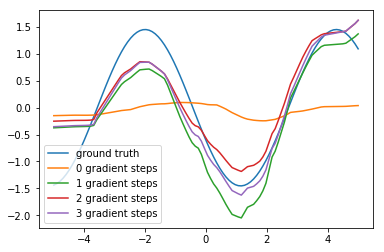

In [119]:
wave = SineWaveTask()
wave.plot(label='ground truth')

for n_inner_ in xrange(4):
    new_model = do_base_learning(model, wave, 
                                 lr_inner=0.01, n_inner=n_inner_)
    wave.plot_model(new_model, label='{} gradient steps'.format(n_inner_))
    
plt.legend()